In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")

Loaded data with 12 cells and 4 background noise models
Plots: on


Fitting background noise...
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     1   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     7.1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │     1   │


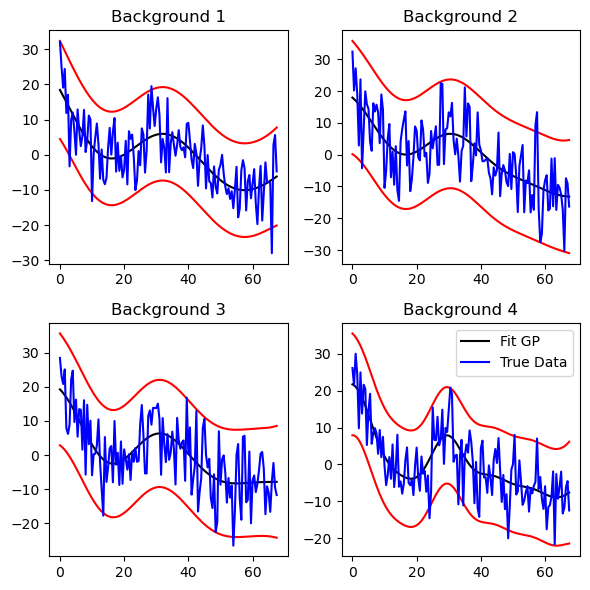

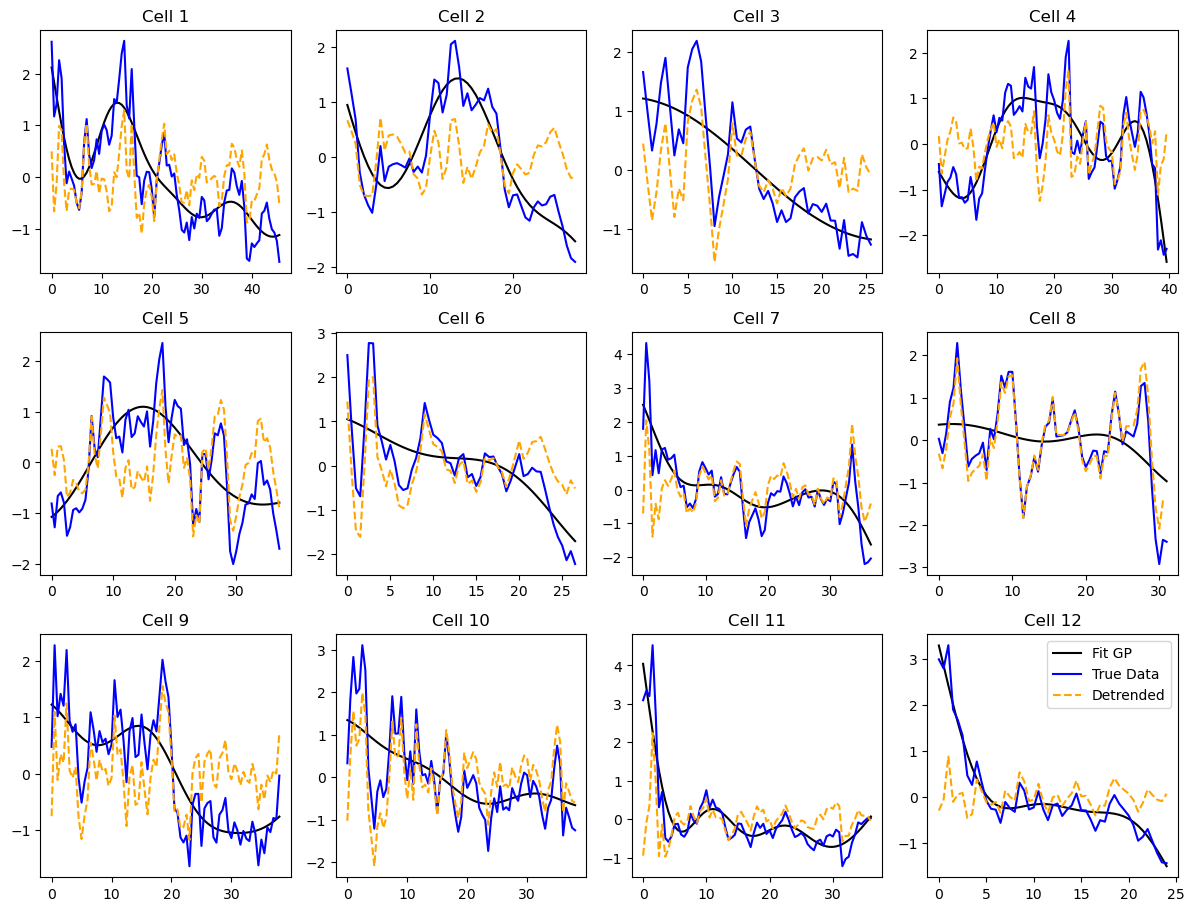

In [2]:
from pyrocell.gp.gpflow import OscillatorDetector

path = "data/hes/Hes1_example.csv"
osc = OscillatorDetector(path)

params = {"verbose": True, "plots": ["background", "detrend"]}
osc.fit_models(**params)